In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Combining CSV's into single dataframe(Label1)

## Tamil language

In [1]:
import pandas as pd
import re
from collections import Counter
import csv
from datasets import Dataset  # HuggingFace Datasets library

# ------------------------------
# 1. Define Helper Functions
# ------------------------------

def read_csv_auto_sep(filepath):
    """
    Read a CSV file by attempting to auto-detect the delimiter.
    Falls back to comma if detection fails, and retries with comma if only one column is detected.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.read(2048)
        try:
            dialect = csv.Sniffer().sniff(sample)
            delimiter = dialect.delimiter
        except csv.Error:
            print(f"Could not detect delimiter for {filepath}. Falling back to comma.")
            delimiter = ','
    df = pd.read_csv(filepath, sep=delimiter, encoding='utf-8', engine='python', on_bad_lines='skip')
    if len(df.columns) == 1:
        print(f"Retrying with comma separator for {filepath}...")
        df = pd.read_csv(filepath, sep=',', encoding='utf-8', engine='python', on_bad_lines='skip')
    return df

def majority_vote(row, annotator_cols):
    """
    Compute majority vote from multiple annotator columns.
    In case of a tie or no votes, returns 0.
    """
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0
    return most_common[0][0]

# ------------------------------
# 2. Read Tamil CSV File
# ------------------------------

# Update the path to your Tamil CSV file (e.g., train_ta_l1.csv)
file_ta = "/home/shubham24165/NLP-Project/task_2/uli-data/training/train_ta_l1.csv"
df_ta = read_csv_auto_sep(file_ta)
print("Columns found in Tamil file:", df_ta.columns.tolist())

# For Tamil, we expect these annotator columns:
ta_annotator_cols = ["ta_a1", "ta_a2", "ta_a3", "ta_a4", "ta_a5"]

# Tag language as Tamil ('ta')
df_ta["language"] = "ta"

# If the 'text' column is not present, try renaming known alternatives:
if "text" not in df_ta.columns:
    if "tweet" in df_ta.columns:
        df_ta.rename(columns={"tweet": "text"}, inplace=True)
    elif "content" in df_ta.columns:
        df_ta.rename(columns={"content": "text"}, inplace=True)
    else:
        raise ValueError("No 'text' column found in the Tamil CSV file.")

# Apply majority vote using Tamil annotator columns
df_ta["final_label"] = df_ta.apply(lambda row: majority_vote(row, ta_annotator_cols), axis=1)

# Keep only the necessary columns
df_ta = df_ta[["text", "final_label", "language"]]
print("Tamil DataFrame preview:")
print(df_ta.head())

# ------------------------------
# 3. Preprocessing Functions (Tamil Only)
# ------------------------------

def preprocess_tamil_text(text):
    """
    Preprocess Tamil text:
      - Removes hashtags, URLs, and handle placeholders.
      - Removes emojis using a regex.
      - Preserves Tamil characters (Unicode range: \u0B80-\u0BFF), numerals, and spaces.
    """
    if not isinstance(text, str):
        return ""
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove handle placeholders
    text = re.sub(r'<handle replaced>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove emojis using a regex
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                               "\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF"
                               "\U0001F700-\U0001F77F]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Preserve only Tamil Unicode characters, numerals, and spaces; remove others.
    text = re.sub(r'[^\u0B80-\u0BFF0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply Tamil preprocessing
df_ta['clean_text'] = df_ta['text'].apply(preprocess_tamil_text)
print("\nPreview with cleaned Tamil text:")
print(df_ta[['text', 'clean_text', 'final_label', 'language']].head())

# ------------------------------
# 4. Convert to HuggingFace Dataset
# ------------------------------

# # Optionally, if you want to work only with the cleaned text, rename 'clean_text' to 'text'
# df_ta = df_ta[['clean_text', 'final_label', 'language']].rename(columns={'clean_text': 'text'})

# # Convert the final Tamil DataFrame to a HuggingFace Dataset
# hf_dataset_ta = Dataset.from_pandas(df_ta)
# print("\nHuggingFace Tamil Dataset Preview:")
# print(hf_dataset_ta[0])


Retrying with comma separator for /home/shubham24165/NLP-Project/task_2/uli-data/training/train_ta_l1.csv...
Columns found in Tamil file: ['text', 'key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
Tamil DataFrame preview:
                                                text final_label language
0     *1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...         0.0       ta
1     சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3      பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆         1.0       ta
4    என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...         1.0       ta

Preview with cleaned Tamil text:
                                                text  \
0     *1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...   
1     சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...   
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா   
3      பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆   
4    என்ன

In [2]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
df_ta = df_ta.drop(columns=["text"])
df_ta = df_ta.rename(columns={"clean_text": "text"})

print(df_ta.head())

  final_label language                                               text
0         0.0       ta  1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம...
1         0.0       ta  சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு...
2         0.0       ta           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3         1.0       ta              பச்சை மொளகா காரம் அம்மா புண்டை நாறும்
4         1.0       ta  என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ஒவ்வொ...


In [3]:
df_ta = df_ta[['text', 'final_label', 'language']]
print(df_ta.head())
print(df_ta.tail(10))  # Prints the last 10 rows

                                                text final_label language
0  1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம...         0.0       ta
1  சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3              பச்சை மொளகா காரம் அம்மா புண்டை நாறும்         1.0       ta
4  என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ஒவ்வொ...         1.0       ta
                                                   text final_label language
6769  நேத்து ஒரு ல இதைத்தான் உரிட்டிட்டு இருந்தானுங்...         0.0       ta
6770  ரயில்ல கல்லு விட்டதுக்கு இப்ப வாயிலயே குடுத்து...         0.0       ta
6771  தேவ்டியா பையா என் சுன்னிக்கு மொதல் பதில் சொல்ல...         1.0       ta
6772                                         மக்கு கூதி         1.0       ta
6773  ஓத்த ஓழுல புன்டயில ஓத்தலம் போட போன வேச புன்டக்...         1.0       ta
6774                              ஒம்மாள படிக்கல் புண்ட         1.0       ta
6775  என்ன எழவுயா

In [ ]:
# Step 1: Install required libraries (if not already installed)
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
!pip install gdown
import gdown

In [ ]:
import gdown
import os

# Google Drive shareable link provided:
drive_link = "https://drive.google.com/file/d/1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw/view?usp=sharing"

# Extract the file ID from the link.
# For this link, the file ID is "1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw"
file_id = "1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw"

# Construct a download URL in the required format:
download_url = f"https://drive.google.com/uc?id={file_id}"

# Set destination path in Colab's local filesystem
destination = "/content/abusexlmr_checkpoint.zip"

# Download the file
gdown.download(download_url, destination, quiet=False)

# Unzip the checkpoint
!unzip {destination} -d /content/abusexlmr_checkpoint

Downloading...
From (original): https://drive.google.com/uc?id=1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw
From (redirected): https://drive.google.com/uc?id=1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw&confirm=t&uuid=62a8be2a-7fb2-4b93-843e-43beb0fdf05e
To: /content/abusexlmr_checkpoint.zip
100%|██████████| 1.80G/1.80G [00:13<00:00, 134MB/s] 


Archive:  /content/abusexlmr_checkpoint.zip
replace /content/abusexlmr_checkpoint/__MACOSX/._abusexlmr? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/._abusexlmr  
replace /content/abusexlmr_checkpoint/abusexlmr/rng_state.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/abusexlmr/rng_state.pth  
replace /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._rng_state.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._rng_state.pth  
replace /content/abusexlmr_checkpoint/abusexlmr/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/abusexlmr/tokenizer_config.json  
replace /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._tokenizer_config.json  
replace /content

## Tokenization using AbuseXLMR tokenizer
(git link: https://github.com/ShareChatAI/MACD)

In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Assume your cleaned DataFrame is called train_df
print(df_ta.head())

# Ensure final_label is numeric
df_ta['final_label'] = pd.to_numeric(df_ta['final_label'], errors='coerce')

# Convert DataFrame to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df_ta)

# For simplicity, perform a train/validation split (e.g., 80/20 split)
dataset_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    "train": dataset_split["train"],
    "validation": dataset_split["test"]
})

# Optional: Inspect the split
print("Train dataset size:", dataset_dict["train"].num_rows)
print("Validation dataset size:", dataset_dict["validation"].num_rows)

# --- Use AbuseXLMR tokenizer ---
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # We use the cleaned 'text' field; adjust max_length as needed
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the dataset (batched for efficiency)
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

# Inspect a sample from the tokenized dataset
print(tokenized_dataset["train"][1000])


                                                text final_label language
0  1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம...         0.0       ta
1  சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3              பச்சை மொளகா காரம் அம்மா புண்டை நாறும்         1.0       ta
4  என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ஒவ்வொ...         1.0       ta
Train dataset size: 5423
Validation dataset size: 1356


Map:   0%|          | 0/5423 [00:00<?, ? examples/s]

Map:   0%|          | 0/1356 [00:00<?, ? examples/s]

{'text': 'அது வந்து நாம சீனாவ பூடுச்சி ஊம்பு ஊம்புன்னு ஊம்பரப்ப அடுத்தவண குத்தம் சொல்ல கூடாது நாம ஊம்பறத நிப்பாட்டினோம்னா அடுத்தவன செருப்ப கலட்டி அடிக்கலாம்', 'final_label': 1.0, 'language': 'ta', 'input_ids': [0, 20313, 38588, 16526, 4548, 201398, 3937, 40413, 9000, 21479, 45237, 45439, 45237, 45439, 52709, 45237, 938, 108471, 7114, 53413, 3937, 13764, 14233, 3770, 938, 33105, 144957, 16526, 4548, 45237, 42749, 9823, 4875, 25884, 20663, 10479, 101477, 938, 15202, 53413, 80387, 19883, 8850, 7114, 59303, 10479, 46170, 187770, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
tokenized_dataset = tokenized_dataset.rename_column("final_label", "labels")

## Finetuning AbuseXLMR(Multi-lingual Representation of Indic Languages)

In [7]:
import os

# Set your custom project name here
os.environ["WANDB_PROJECT"] = "GenderedAbuse_Detection"

In [9]:
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support
from datasets import DatasetDict
from datasets import Value

# Ensure labels are ints
def cast_to_int(example):
    example['labels'] = int(example['labels']) if example['labels'] is not None else 0
    return example

tokenized_dataset = tokenized_dataset.map(cast_to_int)
tokenized_dataset = tokenized_dataset.cast_column("labels", Value("int64"))

# ---- STEP 2: Define compute_metrics ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        "precision": precision,
        "recall": recall,
        "macro_f1": f1
    }

# ---- STEP 3: Load MuRIL model and tokenizer ----
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ---- STEP 4: Define training arguments ----
training_args = TrainingArguments(
    output_dir="/home/shubham24165/NLP-Project/task_2/AbuseXLMR_gendered_abuse_tamil",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,                          # keep the best
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="wandb",                           #Logs to wandb
    run_name="abusexlmr_tamil",                 
)



# ---- STEP 5: Trainer setup ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# ---- STEP 6: Start training ----
trainer.train()

# ---- STEP 7: Evaluate ----
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Map:   0%|          | 0/5423 [00:00<?, ? examples/s]

Map:   0%|          | 0/1356 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5423 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1356 [00:00<?, ? examples/s]

/home/shubham24165/.conda/envs/deeplearning/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1
1,No log,0.439063,0.789063,0.790814,0.789810
2,0.536900,0.432714,0.803207,0.802208,0.787603
3,0.380700,0.453967,0.796258,0.798146,0.786098
4,0.380700,0.513338,0.786786,0.791205,0.782788
5,0.306200,0.612628,0.777506,0.780581,0.778510
6,0.249800,0.696864,0.773631,0.777988,0.774158
7,0.249800,0.764140,0.768125,0.771515,0.769063
8,0.192900,0.909989,0.777399,0.782125,0.775142
9,0.163900,0.950019,0.763904,0.766286,0.764782
10,0.163900,0.986960,0.769748,0.773940,0.770355


Evaluation Results: {'eval_loss': 0.43906325101852417, 'eval_precision': 0.789062706270627, 'eval_recall': 0.7908139887507388, 'eval_macro_f1': 0.7898097709915243, 'eval_runtime': 3.2064, 'eval_samples_per_second': 422.906, 'eval_steps_per_second': 26.51, 'epoch': 10.0}


## Evaluation

In [10]:
import pandas as pd
import re
from collections import Counter
import csv
from datasets import Dataset  # HuggingFace Datasets library

# ------------------------------
# 1. Read the Tamil CSV File
# ------------------------------

def read_csv_auto_sep(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.read(2048)
        try:
            dialect = csv.Sniffer().sniff(sample)
            delimiter = dialect.delimiter
        except csv.Error:
            print(f"Could not detect delimiter for {filepath}. Falling back to comma.")
            delimiter = ','
    df = pd.read_csv(filepath, sep=delimiter, encoding='utf-8', engine='python', on_bad_lines='skip')
    if len(df.columns) == 1:
        print(f"Retrying with comma separator for {filepath}...")
        df = pd.read_csv(filepath, sep=',', encoding='utf-8', engine='python', on_bad_lines='skip')
    return df

# Path to Tamil file
file_ta = "/home/shubham24165/NLP-Project/task_2/uli-data/training/train_ta_l1.csv"
df_ta = read_csv_auto_sep(file_ta)
print("Columns found in Tamil file:", df_ta.columns.tolist())

# ------------------------------
# 2. Apply Majority Vote
# ------------------------------

def majority_vote(row, annotator_cols):
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0
    return most_common[0][0]

# Tamil annotator columns
ta_annotator_cols = ["ta_a1", "ta_a2", "ta_a3", "ta_a4", "ta_a5", "ta_a6"]

# Ensure text column is present
if 'text' not in df_ta.columns:
    if 'tweet' in df_ta.columns:
        df_ta.rename(columns={'tweet': 'text'}, inplace=True)
    elif 'content' in df_ta.columns:
        df_ta.rename(columns={'content': 'text'}, inplace=True)
    else:
        raise ValueError("No 'text' column found in the Tamil CSV file.")

# Add Tamil language tag
df_ta["language"] = "ta"
# Compute final label using majority vote
df_ta["final_label"] = df_ta.apply(lambda row: majority_vote(row, ta_annotator_cols), axis=1)
# Keep necessary columns
df_ta = df_ta[["text", "final_label", "language"]]
print("Tamil DataFrame preview:")
print(df_ta.head())

# ------------------------------
# 3. (Optional) Preprocessing for Tamil
# ------------------------------
# Usually minimal processing is recommended for Tamil script unless you plan to remove emojis, symbols, etc.

def basic_preprocess_tamil(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s\u0B80-\u0BFF]', '', text)  # Remove unwanted chars outside Tamil Unicode
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

# Apply preprocessing
df_ta["clean_text"] = df_ta["text"].apply(basic_preprocess_tamil)
print("\nPreview with cleaned Tamil text:")
print(df_ta[['text', 'clean_text', 'final_label', 'language']].head())

# ------------------------------
# 4. Convert to HuggingFace Dataset
# ------------------------------

test_df = df_ta[["clean_text", "final_label", "language"]].rename(columns={"clean_text": "text"})
# hf_dataset_ta = Dataset.from_pandas(final_df_ta)
# print("\nHuggingFace Dataset Preview (Tamil):")
# print(hf_dataset_ta[0])


Retrying with comma separator for /home/shubham24165/NLP-Project/task_2/uli-data/training/train_ta_l1.csv...
Columns found in Tamil file: ['text', 'key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
Tamil DataFrame preview:
                                                text final_label language
0     *1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...         0.0       ta
1     சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3      பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆         1.0       ta
4    என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...         1.0       ta

Preview with cleaned Tamil text:
                                                text  \
0     *1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...   
1     சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...   
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா   
3      பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆   
4    என்ன

In [11]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
test_df = test_df.rename(columns={"clean_text": "text"})

print(test_df.head())

                                                text final_label language
0  1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம...         0.0       ta
1  சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3        பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்         1.0       ta
4  என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ஒவ்வொ...         1.0       ta


In [12]:
print("Columns found:", test_df.columns.tolist())
test_df = test_df[['text', 'final_label', 'language']]
print(test_df.head())
print(test_df.tail(10))  # Prints the last 10 rows

Columns found: ['text', 'final_label', 'language']
                                                text final_label language
0  1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம...         0.0       ta
1  சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3        பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்         1.0       ta
4  என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ஒவ்வொ...         1.0       ta
                                                   text final_label language
6769  நேத்து ஒரு space ல இதைத்தான் உரிட்டிட்டு இருந்...         0.0       ta
6770  ரயில்ல கல்லு விட்டதுக்கு இப்ப வாயிலயே குடுத்து...         0.0       ta
6771  தேவ்டியா பையா என் சுன்னிக்கு மொதல் பதில் சொல்ல...         1.0       ta
6772                                         மக்கு கூதி         1.0       ta
6773  ஓத்த ஓழுல புன்டயில ஓத்தலம் போட போன வேச புன்டக்...         1.0       ta
6774                              ஒம்மாள பட

In [13]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

# Assume your cleaned test DataFrame is called test_df
print("Test DF preview:")
print(test_df.head())

# Ensure 'final_label' is numeric
test_df['final_label'] = pd.to_numeric(test_df['final_label'], errors='coerce')

# Convert test_df to Hugging Face Dataset
hf_test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer from AbuseXLMR model
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"  # Update path if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Apply tokenization to the test dataset (batched for efficiency)
tokenized_test_dataset = hf_test_dataset.map(tokenize_function, batched=True)

# Inspect a sample from the tokenized dataset
print("Sample tokenized test record:")
print(tokenized_test_dataset[0])  # You can change index as needed


Test DF preview:
                                                text final_label language
0  1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம...         0.0       ta
1  சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு...         0.0       ta
2           தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா         0.0       ta
3        பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்         1.0       ta
4  என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ஒவ்வொ...         1.0       ta


Map:   0%|          | 0/6779 [00:00<?, ? examples/s]

Sample tokenized test record:
{'text': '1 முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம் இல்லை என்பதை நிரூபிக்க 1985ஆம் ஆண்டு வாங்கப்பட்ட பட்டாவை ஆதாரமாகக் காட்டியிருக்கிறார் முகஸ்டாலின் இதற்கு காட்ட வேண்டிய', 'final_label': 0.0, 'language': 'ta', 'input_ids': [0, 106, 10832, 4551, 220391, 6566, 163930, 938, 235186, 35097, 78675, 199802, 11449, 77690, 938, 19688, 67442, 25884, 151962, 12603, 2798, 20231, 100366, 32105, 53442, 18599, 8838, 50667, 7065, 183477, 10239, 1962, 174279, 2782, 130875, 71987, 210093, 130089, 139937, 61300, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unique labels in test dataset: [0 1]

📊 Evaluation on Test Set:
 Precision (macro): 0.8024
 Recall    (macro): 0.8062
 F1 Score  (macro): 0.8037


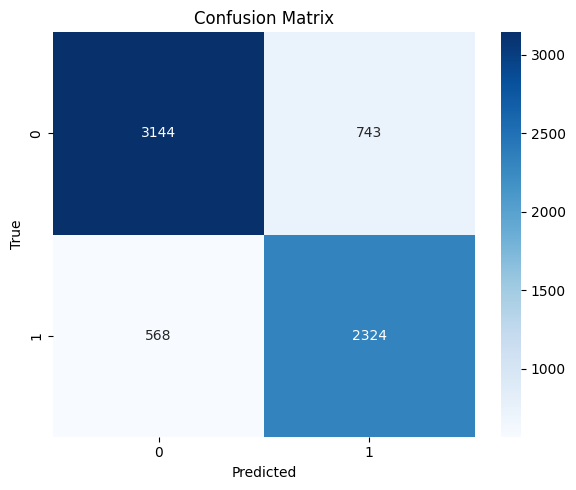

✅ Predictions on test_df saved to: /home/shubham24165/NLP-Project/task_2/predictionsAbuseXLMR_test_tamil.csv


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch

# Step 1: Load trained model from checkpoint
model_checkpoint_path = "/home/shubham24165/NLP-Project/task_2/AbuseXLMR_gendered_abuse_tamil/checkpoint-339"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_path)

# Step 2: Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 3: Setup Trainer (reinitialize with new model)
trainer = Trainer(model=model)

# Step 4: Run predictions on test set
predictions_output = trainer.predict(tokenized_test_dataset)

# Step 5: Extract logits, predicted labels, and true labels
logits = predictions_output.predictions
preds = np.argmax(logits, axis=1)

# Force ground truth labels to be integers. Replace None with default value 0.
labels = np.array([int(x) if x is not None else 0 for x in tokenized_test_dataset['final_label']])

print("Unique labels in test dataset:", np.unique(labels))

# Step 6: Compute macro-averaged metrics
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')

print(f"\n📊 Evaluation on Test Set:")
print(f" Precision (macro): {precision:.4f}")
print(f" Recall    (macro): {recall:.4f}")
print(f" F1 Score  (macro): {f1:.4f}")

# Step 7: Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 8: Collect original input texts from test_df (ensure test_df is properly defined)
input_texts = test_df["text"].tolist()

# Step 9: Save predictions to CSV
df = pd.DataFrame({
    "text": input_texts,
    "true_label": labels,
    "predicted_label": preds
})
csv_path = "/home/shubham24165/NLP-Project/task_2/predictionsAbuseXLMR_test_tamil.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Predictions on test_df saved to: {csv_path}")